## Load Sub & Setup

In [16]:
import pickle
import numpy as np
import gc  # Garbage collector
import os # For path creation
import math # For positional encoding in Transformer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import pywt
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch, butter, lfilter, filtfilt

In [18]:
# --- Configuration ---
PARTICIPANTS = 32 # Set to a smaller number (e.g., 3) for faster testing
EPOCHS = 15 # Reduced for quicker demonstration
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
N_SPLITS_CV = 2  # MODIFIED FOR QUICK TESTING! Use 5 or 10 for actual runs.
TARGET_TASK = 'Valence' # 'Valence' or 'Arousal'
FEATURE_TYPE = 'DE'  # Options: 'CWT', 'PSD', 'DE'

# === List of models to test ===
MODEL_ARCHITECTURES_TO_TEST = ['CNN', 'LSTM', 'TRANSFORMER']

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")
print(f"Selected base feature type: {FEATURE_TYPE}")
print(f"Target task: {TARGET_TASK}")
print(f"Will test model architectures: {MODEL_ARCHITECTURES_TO_TEST}")


# Paths and EEG constants
BASE_PATH = 'C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\deap-dataset\\' # !!! ADJUST THIS PATH !!!
PREPROCESSED_DATA_PATH = os.path.join(BASE_PATH, 'data_preprocessed_python')
# OUTPUT_PATH will be set dynamically inside the loop for each model architecture

FS = 128 # Sampling frequency for DEAP
EEG_CHANNELS_COUNT = 32 # Using only the 32 EEG channels

# Frequency bands for PSD and DE
BANDS = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 48)
}
BAND_NAMES = list(BANDS.keys())

# Model Specific Hyperparameters (These are global starting points, ideally tune per model/feature)
# LSTM
LSTM_HIDDEN_SIZE = 64 # Reduced for faster testing
LSTM_NUM_LAYERS = 1   # Reduced for faster testing
LSTM_DROPOUT = 0.4
# CNNLSTM (CNN part uses SimpleCNN's structure, LSTM part uses above)
# TRANSFORMER
TRANSFORMER_D_MODEL = EEG_CHANNELS_COUNT # Or project EEG_CHANNELS_COUNT to a different d_model
TRANSFORMER_NHEAD = 4 # Must be a divisor of TRANSFORMER_D_MODEL.
TRANSFORMER_NUM_ENCODER_LAYERS = 1 # Reduced for faster testing
TRANSFORMER_DIM_FEEDFORWARD = 128 # Reduced for faster testing
TRANSFORMER_DROPOUT = 0.3


Using device: cpu
Selected base feature type: DE
Target task: Valence
Will test model architectures: ['CNN', 'LSTM', 'TRANSFORMER']


## Data Loading

In [19]:
subjects_data_list = []
subjects_labels_list = []
print(f"Loading data for {PARTICIPANTS} participants...")
for i in range(1, PARTICIPANTS + 1):
    file_name = os.path.join(PREPROCESSED_DATA_PATH, f"s{'0' if i < 10 else ''}{i}.dat")
    try:
        with open(file_name, 'rb') as file:
            subject = pickle.load(file, encoding='latin1')
            subjects_data_list.append(subject['data'][:, :EEG_CHANNELS_COUNT, :]) # Use only EEG channels
            subjects_labels_list.append(subject['labels'])
            del subject
    except FileNotFoundError:
        print(f"File not found: {file_name}. Make sure PREPROCESSED_DATA_PATH is correct.")
        if i == 1: raise # Fail if first participant file is missing
    gc.collect()

all_data_raw = np.concatenate(subjects_data_list, axis=0)
all_labels_raw = np.concatenate(subjects_labels_list, axis=0)
del subjects_data_list, subjects_labels_list # Free memory
gc.collect()

print(f"Original all_data_raw shape: {all_data_raw.shape}")
print(f"Original all_labels_raw shape: {all_labels_raw.shape}")

# Binarize labels
task_idx = 0 if TARGET_TASK == 'Valence' else 1
y_binary_labels = (all_labels_raw[:, task_idx] >= 5).astype(int)
del all_labels_raw # Free memory
gc.collect()

print(f"Target task: {TARGET_TASK} (column {task_idx})")
print(f"Labels shape: {y_binary_labels.shape}, Unique labels: {np.unique(y_binary_labels, return_counts=True)}")



Loading data for 32 participants...
Original all_data_raw shape: (1280, 32, 8064)
Original all_labels_raw shape: (1280, 4)
Target task: Valence (column 0)
Labels shape: (1280,), Unique labels: (array([0, 1]), array([995, 285]))


## Feature Extraction (CWT, PSD, DE)

In [20]:
# --- CWT Feature Extraction ---
def CWT_for_trials(data_trials, fs_cwt, scales_cwt, wavelet_cwt):
    cwt_all_trials = []
    print(f"Calculating CWT features for {data_trials.shape[0]} trials...")
    for trial_idx in tqdm(range(data_trials.shape[0])):
        cwt_trial_channels = []
        for channel_idx in range(data_trials.shape[1]):
            coeffs, _ = pywt.cwt(data_trials[trial_idx, channel_idx], scales_cwt, wavelet_cwt, sampling_period=1/fs_cwt)
            energy_scales = np.sum(np.abs(coeffs)**2, axis=1)
            cwt_trial_channels.append(energy_scales)
        cwt_all_trials.append(np.array(cwt_trial_channels))
    return np.array(cwt_all_trials)

# --- PSD Feature Extraction ---
def PSD_for_trials(data_trials, fs_psd, bands_psd, nperseg_psd=None):
    if nperseg_psd is None: nperseg_psd = fs_psd
    psd_all_trials = []
    print(f"Calculating PSD features for {data_trials.shape[0]} trials...")
    for trial_idx in tqdm(range(data_trials.shape[0])):
        psd_trial_channels = []
        for channel_idx in range(data_trials.shape[1]):
            freqs, psd = welch(data_trials[trial_idx, channel_idx], fs_psd, nperseg=nperseg_psd, scaling='density')
            psd_bands_data = []
            for _, (low_freq, high_freq) in bands_psd.items():
                band_mask = (freqs >= low_freq) & (freqs <= high_freq)
                avg_psd_in_band = np.mean(psd[band_mask]) if np.sum(band_mask) > 0 else 0.0
                psd_bands_data.append(avg_psd_in_band)
            psd_trial_channels.append(np.array(psd_bands_data))
        psd_all_trials.append(np.array(psd_trial_channels))
    return np.array(psd_all_trials)

# --- DE Feature Extraction ---
def butter_bandpass_filter(data, lowcut, highcut, fs_de, order=5):
    nyq = 0.5 * fs_de
    low = lowcut / nyq
    high = highcut / nyq
    if low == high: # Avoid issues with zero-width bands if any definitions are problematic
        print(f"Warning: bandpass filter called with low==high ({lowcut}Hz). Returning zeros or original signal.")
        return np.zeros_like(data) # Or data
    # Ensure low < high after normalization
    if low >= high:
        low, high = high, low # Swap if order is wrong
        if low == high: # if they were equal
             print(f"Warning: bandpass filter called with low==high ({lowcut}Hz) after normalization. Returning zeros.")
             return np.zeros_like(data)

    b, a = butter(order, [low, high], btype='band', analog=False)
    y = filtfilt(b, a, data) # Using filtfilt for zero phase distortion
    return y

def DE_for_trials(data_trials, fs_de, bands_de):
    de_all_trials = []
    print(f"Calculating DE features for {data_trials.shape[0]} trials...")
    for trial_idx in tqdm(range(data_trials.shape[0])):
        de_trial_channels = []
        for channel_idx in range(data_trials.shape[1]):
            de_bands_data = []
            for _, (low_freq, high_freq) in bands_de.items():
                if low_freq >= high_freq: # Skip invalid bands
                    print(f"Warning: Skipping invalid band [{low_freq}, {high_freq}] for DE calculation.")
                    de_bands_data.append(0.0) # Append a neutral value
                    continue
                filtered_signal = butter_bandpass_filter(data_trials[trial_idx, channel_idx], low_freq, high_freq, fs_de)
                variance = np.var(filtered_signal)
                de_val = 0.5 * np.log(2 * np.pi * np.e * (variance + 1e-12)) # Added larger epsilon
                de_bands_data.append(de_val)
            de_trial_channels.append(np.array(de_bands_data))
        de_all_trials.append(np.array(de_trial_channels))
    return np.array(de_all_trials)


## Compute Selected Features (once for all models)

In [21]:
X_selected_features = None
features_filename_suffix = "" # For saving files, if uncommented

if FEATURE_TYPE == 'CWT':
    scales_cwt_param = np.arange(1, 33) # Reduced scales for faster CWT, tune this
    wavelet_cwt_param = 'morl'
    X_selected_features = CWT_for_trials(all_data_raw, FS, scales_cwt_param, wavelet_cwt_param)
    features_filename_suffix = f"cwt_s{len(scales_cwt_param)}"
elif FEATURE_TYPE == 'PSD':
    X_selected_features = PSD_for_trials(all_data_raw, FS, BANDS, nperseg_psd=FS*2) # 2-sec segment for Welch
    features_filename_suffix = "psd_5bands"
elif FEATURE_TYPE == 'DE':
    X_selected_features = DE_for_trials(all_data_raw, FS, BANDS)
    features_filename_suffix = "de_5bands"
else:
    raise ValueError(f"Unsupported FEATURE_TYPE: {FEATURE_TYPE}")

print(f"Shape of selected features ({FEATURE_TYPE}) for all data: {X_selected_features.shape}")

del all_data_raw # Free memory
gc.collect()


Calculating DE features for 1280 trials...


100%|██████████| 1280/1280 [01:11<00:00, 17.78it/s]


Shape of selected features (DE) for all data: (1280, 32, 5)


9

## Deep Learning Model Definitions

In [22]:
# --- SimpleCNN ---
class SimpleCNN(nn.Module):
    def __init__(self, input_channels, num_features_per_channel, num_classes=1, cnn_dropout_rate=0.5):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        
        self.pool = nn.MaxPool1d(2)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(output_size=max(1, num_features_per_channel // 8)) # Ensure output_size > 0
        
        # Determine if pooling layers are active based on initial num_features_per_channel
        _seq_len = num_features_per_channel
        self.pool1_active = _seq_len // 2 >= 1
        if self.pool1_active: _seq_len //= 2
        
        self.pool2_active = _seq_len // 2 >= 1
        if self.pool2_active: _seq_len //= 2

        # The output size for adaptive_pool ensures it doesn't try to pool an empty sequence
        final_pooled_size = max(1, num_features_per_channel // (2** (self.pool1_active + self.pool2_active + 1))) # +1 for one more potential pool before adaptive
        if final_pooled_size < 1: final_pooled_size = 1 # safety
        self.adaptive_pool = nn.AdaptiveAvgPool1d(output_size=final_pooled_size)

        flattened_size = 256 * final_pooled_size
        
        self.dropout = nn.Dropout(cnn_dropout_rate)
        self.fc1 = nn.Linear(flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        if self.pool1_active: x = self.pool(x)
        x = self.dropout(x)

        x = F.relu(self.bn2(self.conv2(x)))
        if self.pool2_active: x = self.pool(x)
        x = self.dropout(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.adaptive_pool(x) # Adaptive pooling to handle varying sequence lengths robustly
        x = self.dropout(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# --- LSTM Model ---
class LSTMModel(nn.Module):
    def __init__(self, input_size_lstm, hidden_size_lstm, num_layers_lstm, num_classes=1, dropout_lstm=0.5):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size_lstm, 
                              hidden_size=hidden_size_lstm,
                              num_layers=num_layers_lstm, 
                              batch_first=True, 
                              dropout=dropout_lstm if num_layers_lstm > 1 else 0,
                              bidirectional=True)
        self.fc = nn.Linear(hidden_size_lstm * 2, num_classes) # *2 for bidirectional
        self.dropout_fc = nn.Dropout(dropout_lstm)

    def forward(self, x):
        # x: (batch, num_eeg_channels, num_features_per_channel)
        # LSTM: (batch, seq_len=num_features_per_channel, input_size=num_eeg_channels)
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]
        out = self.dropout_fc(out)
        out = self.fc(out)
        return out

# --- CNN-LSTM Model ---
class CNNLSTMModel(nn.Module):
    def __init__(self, input_channels_cnn, num_features_per_channel_cnn, 
                 lstm_hidden_size, lstm_num_layers, num_classes=1, 
                 cnn_dropout_rate=0.5, lstm_dropout_rate=0.5):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels_cnn, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.pool1_active = num_features_per_channel_cnn // 2 >= 1
        cnn_output_seq_len = num_features_per_channel_cnn // 2 if self.pool1_active else num_features_per_channel_cnn
        if cnn_output_seq_len < 1: cnn_output_seq_len = 1

        cnn_output_channels = 128 # from conv2
        self.cnn_dropout = nn.Dropout(cnn_dropout_rate)

        self.lstm = nn.LSTM(input_size=cnn_output_channels,
                              hidden_size=lstm_hidden_size,
                              num_layers=lstm_num_layers,
                              batch_first=True,
                              dropout=lstm_dropout_rate if lstm_num_layers > 1 else 0,
                              bidirectional=True)
        self.fc = nn.Linear(lstm_hidden_size * 2, num_classes)
        self.lstm_fc_dropout = nn.Dropout(lstm_dropout_rate)

    def forward(self, x):
        # CNN part
        x = F.relu(self.bn1(self.conv1(x)))
        if self.pool1_active: x = self.pool1(x)
        x = self.cnn_dropout(x)
        x = F.relu(self.bn2(self.conv2(x)))
        # x shape: (batch, cnn_output_channels, cnn_output_seq_len)
        
        # LSTM part
        x = x.permute(0, 2, 1) # (batch, cnn_output_seq_len, cnn_output_channels)
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]
        out = self.lstm_fc_dropout(out)
        out = self.fc(out)
        return out

# --- Positional Encoding for Transformer ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000): # max_len should be >= max sequence length
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe) # Shape: (max_len, 1, d_model)

    def forward(self, x):
        # x shape: (seq_len, batch_size, d_model)
        x = x + self.pe[:x.size(0)] # Add PE to the sequence
        return self.dropout(x)

# --- Transformer Model ---
class TransformerModel(nn.Module):
    def __init__(self, input_dim_transformer, d_model_transformer, nhead_transformer, 
                 num_encoder_layers_transformer, dim_feedforward_transformer, 
                 num_classes=1, dropout_transformer=0.5, max_seq_len_transformer=100):
        super().__init__()
        self.d_model = d_model_transformer
        self.input_projection = nn.Linear(input_dim_transformer, d_model_transformer)
        self.pos_encoder = PositionalEncoding(d_model_transformer, dropout_transformer, max_len=max_seq_len_transformer)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model_transformer, nhead=nhead_transformer, 
                                                    dim_feedforward=dim_feedforward_transformer,
                                                    dropout=dropout_transformer, batch_first=False)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers_transformer)
        self.fc_out = nn.Linear(d_model_transformer, num_classes)
        self.dropout_fc = nn.Dropout(dropout_transformer)

    def forward(self, x):
        # x: (batch, num_eeg_channels (input_dim_transformer), num_features_per_channel (seq_len))
        x = x.permute(2, 0, 1) # (seq_len, batch, input_dim_transformer)
        x = self.input_projection(x) # (seq_len, batch, d_model)
        x = self.pos_encoder(x * math.sqrt(self.d_model)) # Scale embedding before PE
        transformer_out = self.transformer_encoder(x) # (seq_len, batch, d_model)
        out = transformer_out.mean(dim=0) # Global Average Pooling over seq_len: (batch, d_model)
        out = self.dropout_fc(out)
        out = self.fc_out(out)
        return out


## Training and Evaluation Loop

In [23]:
def train_model_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds, all_targets = [], []
    for inputs, targets in train_loader: # Use tqdm here for epoch progress if desired
        inputs, targets = inputs.to(device), targets.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        preds = torch.sigmoid(outputs) >= 0.5
        all_preds.extend(preds.cpu().numpy().flatten())
        all_targets.extend(targets.cpu().numpy().flatten())
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(all_targets, all_preds)
    return epoch_loss, epoch_acc

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) >= 0.5
            all_preds.extend(preds.cpu().numpy().flatten())
            all_targets.extend(targets.cpu().numpy().flatten())
            
    epoch_loss = running_loss / len(test_loader.dataset)
    
    # Handle cases with no predictions or targets for robust metric calculation
    if not all_targets or not all_preds: # Or if all_targets has only one class after a bad split
        print("Warning: Empty targets or predictions in evaluation. Returning zero metrics.")
        return epoch_loss, 0, 0, 0, 0, np.array([[0,0],[0,0]])

    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    
    # Ensure CM is 2x2, even if one class was not present/predicted
    unique_labels_in_fold = np.unique(np.concatenate((all_targets, np.array(all_preds, dtype=int).flatten())))
    cm_labels = [0, 1] # Define the full set of possible labels
    cm = confusion_matrix(all_targets, all_preds, labels=cm_labels)

    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    return epoch_loss, acc, f1, recall, specificity, cm



## Cross-Validation Loop



PROCESSING MODEL ARCHITECTURE: CNN with DE features for Valence

Output for this run will be saved to: C:\Users\ferri\Downloads\PoliTO\Tesi\DSs\Emotion-Stress\deap-dataset\model_outputs_run_32p\cnn_de_valence

--- Fold 1/2 for CNN ---
Fold 1: Training CNN on 640 samples, testing on 640 samples.
  Epoch 3/15 => Train Loss: 0.5816, Acc: 0.7594 | Val Loss: 0.6156, Acc: 0.7781, F1: 0.0000
  Epoch 6/15 => Train Loss: 0.5512, Acc: 0.7750 | Val Loss: 0.5778, Acc: 0.7781, F1: 0.0000
  Epoch 9/15 => Train Loss: 0.5336, Acc: 0.7766 | Val Loss: 0.5660, Acc: 0.7781, F1: 0.0000
  Epoch 12/15 => Train Loss: 0.5419, Acc: 0.7766 | Val Loss: 0.5594, Acc: 0.7781, F1: 0.0000
  Epoch 15/15 => Train Loss: 0.5307, Acc: 0.7750 | Val Loss: 0.5599, Acc: 0.7781, F1: 0.0000
  Fold 1 (CNN/DE) Final Test => Acc: 0.7781, F1: 0.0000

--- Fold 2/2 for CNN ---
Fold 2: Training CNN on 640 samples, testing on 640 samples.
  Epoch 3/15 => Train Loss: 0.5835, Acc: 0.7531 | Val Loss: 0.6154, Acc: 0.7766, F1: 0.0000
  Epo

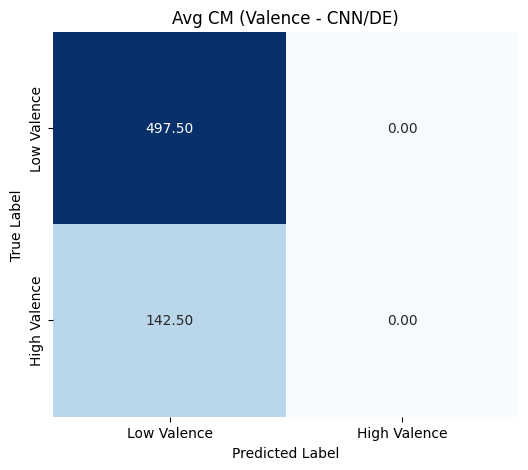

Summary text file saved to C:\Users\ferri\Downloads\PoliTO\Tesi\DSs\Emotion-Stress\deap-dataset\model_outputs_run_32p\cnn_de_valence\summary_results_cnn.txt
--- Finished processing for CNN ---


PROCESSING MODEL ARCHITECTURE: LSTM with DE features for Valence

Output for this run will be saved to: C:\Users\ferri\Downloads\PoliTO\Tesi\DSs\Emotion-Stress\deap-dataset\model_outputs_run_32p\lstm_de_valence

--- Fold 1/2 for LSTM ---
Fold 1: Training LSTM on 640 samples, testing on 640 samples.
  Epoch 3/15 => Train Loss: 0.6681, Acc: 0.7016 | Val Loss: 0.6635, Acc: 0.7734, F1: 0.0136
  Epoch 6/15 => Train Loss: 0.6414, Acc: 0.7688 | Val Loss: 0.6399, Acc: 0.7781, F1: 0.0000
  Epoch 9/15 => Train Loss: 0.6121, Acc: 0.7750 | Val Loss: 0.6163, Acc: 0.7781, F1: 0.0000
  Epoch 12/15 => Train Loss: 0.5885, Acc: 0.7750 | Val Loss: 0.5945, Acc: 0.7781, F1: 0.0000
  Epoch 15/15 => Train Loss: 0.5627, Acc: 0.7750 | Val Loss: 0.5764, Acc: 0.7781, F1: 0.0000
  Fold 1 (LSTM/DE) Final Test => Acc: 0.778

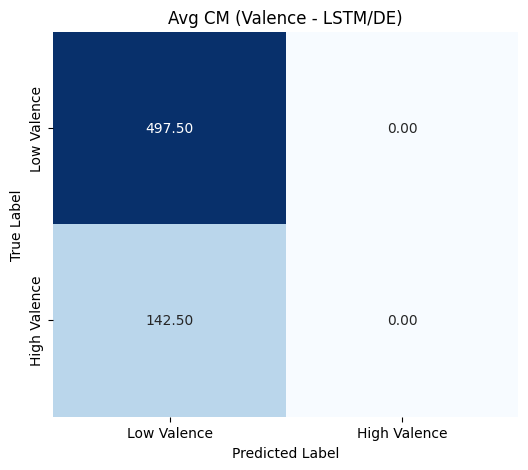

Summary text file saved to C:\Users\ferri\Downloads\PoliTO\Tesi\DSs\Emotion-Stress\deap-dataset\model_outputs_run_32p\lstm_de_valence\summary_results_lstm.txt
--- Finished processing for LSTM ---


PROCESSING MODEL ARCHITECTURE: TRANSFORMER with DE features for Valence

Output for this run will be saved to: C:\Users\ferri\Downloads\PoliTO\Tesi\DSs\Emotion-Stress\deap-dataset\model_outputs_run_32p\transformer_de_valence

--- Fold 1/2 for TRANSFORMER ---
Fold 1: Training TRANSFORMER on 640 samples, testing on 640 samples.


C:\Users\ferri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


  Epoch 3/15 => Train Loss: 0.6212, Acc: 0.6625 | Val Loss: 0.5798, Acc: 0.7391, F1: 0.1347
  Epoch 6/15 => Train Loss: 0.5592, Acc: 0.7438 | Val Loss: 0.5477, Acc: 0.7734, F1: 0.0136
  Epoch 9/15 => Train Loss: 0.5573, Acc: 0.7656 | Val Loss: 0.5362, Acc: 0.7781, F1: 0.0000
  Epoch 12/15 => Train Loss: 0.5333, Acc: 0.7734 | Val Loss: 0.5329, Acc: 0.7781, F1: 0.0000
  Epoch 15/15 => Train Loss: 0.5408, Acc: 0.7734 | Val Loss: 0.5307, Acc: 0.7781, F1: 0.0000
  Fold 1 (TRANSFORMER/DE) Final Test => Acc: 0.7781, F1: 0.0000

--- Fold 2/2 for TRANSFORMER ---
Fold 2: Training TRANSFORMER on 640 samples, testing on 640 samples.


C:\Users\ferri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


  Epoch 3/15 => Train Loss: 0.6266, Acc: 0.6594 | Val Loss: 0.6036, Acc: 0.7063, F1: 0.2713
  Epoch 6/15 => Train Loss: 0.5628, Acc: 0.7578 | Val Loss: 0.5508, Acc: 0.7578, F1: 0.0606
  Epoch 9/15 => Train Loss: 0.5378, Acc: 0.7750 | Val Loss: 0.5346, Acc: 0.7734, F1: 0.0000
  Epoch 12/15 => Train Loss: 0.5217, Acc: 0.7766 | Val Loss: 0.5308, Acc: 0.7766, F1: 0.0000
  Epoch 15/15 => Train Loss: 0.5197, Acc: 0.7797 | Val Loss: 0.5307, Acc: 0.7750, F1: 0.0000
  Fold 2 (TRANSFORMER/DE) Final Test => Acc: 0.7750, F1: 0.0000

--- CV Results Summary for TRANSFORMER (Features: DE, Task: Valence) ---
Avg Accuracy: 0.7766 +/- 0.0016
Avg F1-score: 0.0000 +/- 0.0000
Avg Recall (Sensitivity): 0.0000
Avg Specificity: 0.9990
Average CM plot saved to C:\Users\ferri\Downloads\PoliTO\Tesi\DSs\Emotion-Stress\deap-dataset\model_outputs_run_32p\transformer_de_valence\avg_cm_valence_transformer_DE_32p_15e.png


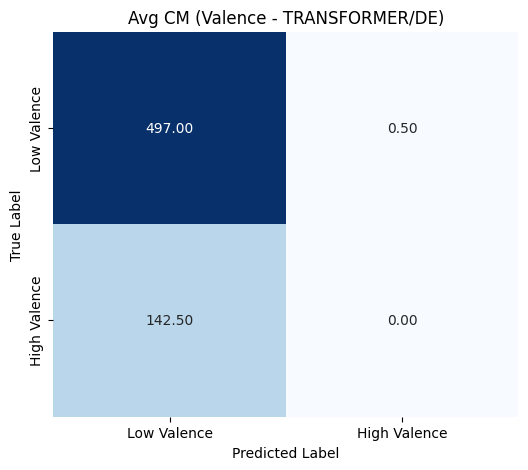

Summary text file saved to C:\Users\ferri\Downloads\PoliTO\Tesi\DSs\Emotion-Stress\deap-dataset\model_outputs_run_32p\transformer_de_valence\summary_results_transformer.txt
--- Finished processing for TRANSFORMER ---


All specified model architectures have been processed.


In [24]:
# Outer loop for iterating through different model architectures
for current_model_architecture_iteration in MODEL_ARCHITECTURES_TO_TEST:
    # Set the global MODEL_ARCHITECTURE for this run (used by print statements, file names)
    MODEL_ARCHITECTURE = current_model_architecture_iteration
    
    print(f"\n\n{'='*25}")
    print(f"PROCESSING MODEL ARCHITECTURE: {MODEL_ARCHITECTURE} with {FEATURE_TYPE} features for {TARGET_TASK}")
    print(f"{'='*25}\n")

    # Define a specific output path for artifacts of this model architecture and feature type
    CURRENT_OUTPUT_PATH = os.path.join(BASE_PATH, f'model_outputs_run_{PARTICIPANTS}p', f'{MODEL_ARCHITECTURE.lower()}_{FEATURE_TYPE.lower()}_{TARGET_TASK.lower()}')
    if not os.path.exists(CURRENT_OUTPUT_PATH):
        os.makedirs(CURRENT_OUTPUT_PATH)
    print(f"Output for this run will be saved to: {CURRENT_OUTPUT_PATH}")

    skf = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=42)
    fold_results = [] # Reset results for each new architecture

    # --- Cross-Validation Loop for the current MODEL_ARCHITECTURE ---
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_selected_features, y_binary_labels)):
        print(f"\n--- Fold {fold+1}/{N_SPLITS_CV} for {MODEL_ARCHITECTURE} ---")

        X_train_fold, X_test_fold = X_selected_features[train_idx], X_selected_features[test_idx]
        y_train_fold, y_test_fold = y_binary_labels[train_idx], y_binary_labels[test_idx]

        # Scaling
        scaler = StandardScaler()
        n_trials_train, n_chans_train, n_feats_train = X_train_fold.shape
        X_train_fold_r = X_train_fold.reshape(n_trials_train, -1)
        X_train_fold_s_r = scaler.fit_transform(X_train_fold_r)
        X_train_fold_s = X_train_fold_s_r.reshape(n_trials_train, n_chans_train, n_feats_train)

        n_trials_test, n_chans_test, n_feats_test = X_test_fold.shape
        X_test_fold_r = X_test_fold.reshape(n_trials_test, -1)
        X_test_fold_s_r = scaler.transform(X_test_fold_r)
        X_test_fold_s = X_test_fold_s_r.reshape(n_trials_test, n_chans_test, n_feats_test)
        
        train_dataset = TensorDataset(torch.from_numpy(X_train_fold_s).float(), torch.from_numpy(y_train_fold).float())
        test_dataset = TensorDataset(torch.from_numpy(X_test_fold_s).float(), torch.from_numpy(y_test_fold).float())

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0) # Set num_workers=0 if issues
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

        # Model Instantiation
        model = None
        num_input_eeg_channels = X_selected_features.shape[1] # Should be EEG_CHANNELS_COUNT
        num_features_per_eeg_channel = X_selected_features.shape[2] # e.g., num CWT scales or num PSD/DE bands

        # Adjust TRANSFORMER_NHEAD if current D_MODEL (from EEG_CHANNELS_COUNT) is not divisible
        current_transformer_d_model = TRANSFORMER_D_MODEL # Could be num_input_eeg_channels or a separate projected dim
        current_transformer_nhead = TRANSFORMER_NHEAD
        if MODEL_ARCHITECTURE == 'TRANSFORMER':
             # If d_model is not explicitly projected from num_input_eeg_channels, and is set to num_input_eeg_channels
            if current_transformer_d_model != num_input_eeg_channels and current_transformer_d_model % TRANSFORMER_NHEAD != 0 : # if d_model is fixed but input_dim is diff, projection handles it.
                 # This case: d_model is fixed (e.g. 32), and n_head needs to divide it.
                 pass # input_projection in TransformerModel handles matching to d_model. nhead must divide d_model.
            
            if current_transformer_d_model % TRANSFORMER_NHEAD != 0: # Ensure nhead divides d_model
                possible_nheads = [h for h in range(1, min(current_transformer_d_model, 8) + 1) if current_transformer_d_model % h == 0]
                if not possible_nheads: current_transformer_nhead = 1
                else: current_transformer_nhead = max(possible_nheads)
                print(f"Adjusted TRANSFORMER_NHEAD to {current_transformer_nhead} for d_model={current_transformer_d_model}")


        if MODEL_ARCHITECTURE == 'CNN':
            model = SimpleCNN(input_channels=num_input_eeg_channels, 
                              num_features_per_channel=num_features_per_eeg_channel, 
                              num_classes=1, cnn_dropout_rate=0.5).to(DEVICE)
        elif MODEL_ARCHITECTURE == 'LSTM':
            model = LSTMModel(input_size_lstm=num_input_eeg_channels,
                              hidden_size_lstm=LSTM_HIDDEN_SIZE,
                              num_layers_lstm=LSTM_NUM_LAYERS,
                              num_classes=1, dropout_lstm=LSTM_DROPOUT).to(DEVICE)
        elif MODEL_ARCHITECTURE == 'CNNLSTM':
            model = CNNLSTMModel(input_channels_cnn=num_input_eeg_channels,
                                 num_features_per_channel_cnn=num_features_per_eeg_channel,
                                 lstm_hidden_size=LSTM_HIDDEN_SIZE,
                                 lstm_num_layers=LSTM_NUM_LAYERS,
                                 num_classes=1, cnn_dropout_rate=0.5, lstm_dropout_rate=LSTM_DROPOUT).to(DEVICE)
        elif MODEL_ARCHITECTURE == 'TRANSFORMER':
            model = TransformerModel(input_dim_transformer=num_input_eeg_channels, # This is the feature dim per step after permutation
                                     d_model_transformer=current_transformer_d_model, # Internal model dim
                                     nhead_transformer=current_transformer_nhead,
                                     num_encoder_layers_transformer=TRANSFORMER_NUM_ENCODER_LAYERS,
                                     dim_feedforward_transformer=TRANSFORMER_DIM_FEEDFORWARD,
                                     num_classes=1, dropout_transformer=TRANSFORMER_DROPOUT,
                                     max_seq_len_transformer=num_features_per_eeg_channel).to(DEVICE)
        else:
            raise ValueError(f"Unsupported MODEL_ARCHITECTURE: {MODEL_ARCHITECTURE}")

        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        
        print(f"Fold {fold+1}: Training {MODEL_ARCHITECTURE} on {len(train_idx)} samples, testing on {len(test_idx)} samples.")
        
        best_fold_val_acc = 0.0 # For saving best model within a fold if desired

        for epoch in range(EPOCHS):
            train_loss, train_acc = train_model_epoch(model, train_loader, criterion, optimizer, DEVICE)
            val_loss, val_acc, val_f1, val_recall, val_specificity, val_cm = evaluate_model(model, test_loader, criterion, DEVICE) # Using test set as validation for this fold
            
            if (epoch + 1) % max(1, EPOCHS // 5) == 0 or epoch == EPOCHS -1 : # Print update less frequently
                print(f"  Epoch {epoch+1}/{EPOCHS} => "
                      f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                      f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
            
            if val_acc > best_fold_val_acc:
                best_fold_val_acc = val_acc
                # Optional: Save model checkpoint for the best epoch of this fold
                # torch.save(model.state_dict(), os.path.join(CURRENT_OUTPUT_PATH, f"model_{MODEL_ARCHITECTURE.lower()}_fold{fold+1}_best.pth"))


        # Evaluate final model state from the last epoch for this fold
        final_test_loss, final_test_acc, final_test_f1, final_test_recall, final_test_specificity, final_test_cm = evaluate_model(model, test_loader, criterion, DEVICE)
        fold_results.append({
            'fold': fold + 1, 'accuracy': final_test_acc, 'f1_score': final_test_f1,
            'recall (sensitivity)': final_test_recall, 'specificity': final_test_specificity,
            'confusion_matrix': final_test_cm
        })
        print(f"  Fold {fold+1} ({MODEL_ARCHITECTURE}/{FEATURE_TYPE}) Final Test => Acc: {final_test_acc:.4f}, F1: {final_test_f1:.4f}")

    # --- End of Cross-Validation Loop for the current MODEL_ARCHITECTURE ---

    # --- Aggregate and Display Results for the current MODEL_ARCHITECTURE ---
    print(f"\n--- CV Results Summary for {MODEL_ARCHITECTURE} (Features: {FEATURE_TYPE}, Task: {TARGET_TASK}) ---")
    
    if not fold_results:
        print("No fold results to aggregate.")
    else:
        avg_accuracy = np.mean([res['accuracy'] for res in fold_results])
        avg_f1_score = np.mean([res['f1_score'] for res in fold_results])
        avg_recall = np.mean([res['recall (sensitivity)'] for res in fold_results])
        avg_specificity = np.mean([res['specificity'] for res in fold_results])
        std_accuracy = np.std([res['accuracy'] for res in fold_results])
        std_f1_score = np.std([res['f1_score'] for res in fold_results])

        print(f"Avg Accuracy: {avg_accuracy:.4f} +/- {std_accuracy:.4f}")
        print(f"Avg F1-score: {avg_f1_score:.4f} +/- {std_f1_score:.4f}")
        print(f"Avg Recall (Sensitivity): {avg_recall:.4f}")
        print(f"Avg Specificity: {avg_specificity:.4f}")

        # Plot average confusion matrix
        # Ensure all CMs are valid 2x2 arrays before averaging
        valid_cms = [res['confusion_matrix'] for res in fold_results if isinstance(res['confusion_matrix'], np.ndarray) and res['confusion_matrix'].shape == (2,2)]
        if valid_cms:
            avg_cm = np.mean(valid_cms, axis=0)
            plt.figure(figsize=(6,5))
            sns.heatmap(avg_cm, annot=True, fmt='.2f', cmap='Blues', cbar=False,
                        xticklabels=[f'Low {TARGET_TASK}', f'High {TARGET_TASK}'],
                        yticklabels=[f'Low {TARGET_TASK}', f'High {TARGET_TASK}'])
            plt.xlabel('Predicted Label'); plt.ylabel('True Label')
            plt.title(f'Avg CM ({TARGET_TASK} - {MODEL_ARCHITECTURE}/{FEATURE_TYPE})')
            plot_filename = f"avg_cm_{TARGET_TASK.lower()}_{MODEL_ARCHITECTURE.lower()}_{FEATURE_TYPE}_{PARTICIPANTS}p_{EPOCHS}e.png"
            plt.savefig(os.path.join(CURRENT_OUTPUT_PATH, plot_filename))
            print(f"Average CM plot saved to {os.path.join(CURRENT_OUTPUT_PATH, plot_filename)}")
            plt.show()
        else:
            print(f"Could not compute or display average CM for {MODEL_ARCHITECTURE} (no valid 2x2 CMs found).")
        
        # Save detailed results to a text file for this model architecture
        results_txt_filename = f"summary_results_{MODEL_ARCHITECTURE.lower()}.txt"
        with open(os.path.join(CURRENT_OUTPUT_PATH, results_txt_filename), "w") as f:
            f.write(f"Target Task: {TARGET_TASK}, Model: {MODEL_ARCHITECTURE}, Features: {FEATURE_TYPE}\n")
            f.write(f"Participants: {PARTICIPANTS}, Epochs: {EPOCHS}, CV Folds: {N_SPLITS_CV}\n")
            f.write(f"Learning Rate: {LEARNING_RATE}, Batch Size: {BATCH_SIZE}\n\n")
            f.write(f"Avg Accuracy: {avg_accuracy:.4f} +/- {std_accuracy:.4f}\n")
            f.write(f"Avg F1-score: {avg_f1_score:.4f} +/- {std_f1_score:.4f}\n")
            f.write(f"Avg Recall (Sensitivity): {avg_recall:.4f}\n")
            f.write(f"Avg Specificity: {avg_specificity:.4f}\n\n")
            f.write("--- Individual Fold Results ---\n")
            for res_idx, res in enumerate(fold_results):
                f.write(f" Fold {res.get('fold', res_idx + 1)}:\n")
                f.write(f"  Accuracy: {res.get('accuracy', 'N/A'):.4f}\n")
                f.write(f"  F1-score: {res.get('f1_score', 'N/A'):.4f}\n")
                f.write(f"  Recall: {res.get('recall (sensitivity)', 'N/A'):.4f}\n")
                f.write(f"  Specificity: {res.get('specificity', 'N/A'):.4f}\n")
                cm_str = np.array2string(res.get('confusion_matrix', np.array([[]])), separator=', ', prefix='  CM: ')
                f.write(f"  CM:\n{cm_str}\n\n")
        print(f"Summary text file saved to {os.path.join(CURRENT_OUTPUT_PATH, results_txt_filename)}")

    print(f"--- Finished processing for {MODEL_ARCHITECTURE} ---")
# --- End of Outer Loop for Model Architectures ---

print("\n\nAll specified model architectures have been processed.")
